# Datathon de Mobilidade Urbana 2024

Este notebook carrega e manipula as bases de dados utilizadas para a análise da relação entre as internações do SUS associadas à acidentes com transportes terrestres, óbitos do mesmo tipo e a carteira de investimentos da SEMOB, nos marcos do Datathon de Mobilidade Urbana proposto pela Secretaria.

In [1]:
from functools import reduce
import geopandas
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd

In [2]:
# Localização das bases de dados no sistema de arquivos local
SIHSUS = 'sihsus/etlsih_transito.zip'
FROTA = 'simu/simu-frota-mun_T.zip'
CARTEIRA = 'simu/simu-carteira-mun-T.zip'
ATLAS_IPEA = 'atlas_ipea/bitos-em-acidentes-de-transporte.csv'
REG_SAUDE = 'shapefile_das_regionais_de_saude_sus/DTB.csv'
SHP_REG_SAUDE = 'shapefile_das_regionais_de_saude_sus/br_regionais_simplificado.zip'

## Carregamento das bases de dados

Esta seção carrega todas as bases de dados que serão utilizadas na análise e opera um enriquecimento mais ou menos simples onde for necessário. Transformações, como recortes temporais e agrupamentos serão realizados na seção seguinte.

### SIMU - frota e população

Dados de frotas de veículos, mantida pelo Senatran e disponível para download pelo [SIMU](https://bigdata-arquivos.icict.fiocruz.br/PUBLICO/SIMU/bases_dados/FROTA/simu-frota-mun_T.zip).

Apenas uma pequena correção é feita na coluna `mun_codigo_adotado`, onde ela tem valor igual a zero. A investigação mostra que este caso corresponde ao município de Nazária-PI, que tem o código do IBGE facilmente acessível na coluna `Código IBGE`.

Neste trabalho, usamos a base de frota veicular para referência tanto da própria frota, quanto da população estimada em cada município em determinado ano.

In [3]:
frota = pd.read_csv(FROTA)
frota.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66840 entries, 0 to 66839
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Código IBGE                66840 non-null  int64  
 1   Município                  66840 non-null  object 
 2   ano                        66840 non-null  int64  
 3   TOTAL_VEICULOS             66752 non-null  float64
 4   AUTOMOVEL                  66752 non-null  float64
 5   BONDE                      66752 non-null  float64
 6   CAMINHAO                   66752 non-null  float64
 7   CAMINHAO TRATOR            66752 non-null  float64
 8   CAMINHONETE                66752 non-null  float64
 9   CAMIONETA                  66752 non-null  float64
 10  CHASSI PLATAF              66752 non-null  float64
 11  CICLOMOTOR                 66752 non-null  float64
 12  MICRO-ONIBUS               66752 non-null  float64
 13  MOTOCICLETA                66752 non-null  flo

In [4]:
frota.loc[frota.mun_codigo_adotado == 0]

,Código IBGE,Município,ano,TOTAL_VEICULOS,AUTOMOVEL,BONDE,CAMINHAO,CAMINHAO TRATOR,CAMINHONETE,CAMIONETA,...,mun_LONGITUDE,mun_ALTITUDE,mun_AREA,mun_codigo_adotado,uf_SIGLA_UF,uf_NOME_UF,uf_CODIGO_UF,Região,uf_REGIAO,mun_coordenadas
3106,2206720,Nazária,2010,42.0,16.0,0.0,2.0,0.0,1.0,0.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
8676,2206720,Nazária,2011,176.0,38.0,0.0,4.0,1.0,9.0,0.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
14246,2206720,Nazária,2012,280.0,61.0,0.0,6.0,0.0,11.0,0.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
19816,2206720,Nazária,2013,432.0,97.0,0.0,9.0,0.0,21.0,2.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
25386,2206720,Nazária,2014,556.0,119.0,0.0,17.0,0.0,34.0,1.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
30956,2206720,Nazária,2015,664.0,153.0,0.0,17.0,0.0,44.0,3.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
36526,2206720,Nazária,2016,757.0,179.0,0.0,22.0,1.0,54.0,3.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
42096,2206720,Nazária,2017,857.0,211.0,0.0,22.0,1.0,61.0,5.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
47666,2206720,Nazária,2018,938.0,221.0,0.0,21.0,1.0,75.0,5.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"
53236,2206720,Nazária,2019,1005.0,250.0,0.0,26.0,1.0,79.0,5.0,...,-42.8083,72,363589,0,PI,PIAUI,22,NE,Nordeste,"-5.36083,-42.8083"


In [5]:
frota['mun_codigo_adotado'] = frota['mun_codigo_adotado'].replace(0, 220672)

### SIMU - Carteira

Carteira de empreendimentos da [Secretaria Nacional de Mobilidade Urbana (SEMOB)](https://www.gov.br/cidades/pt-br/assuntos/mobilidade-urbana), diponível para download pelo [SIMU](https://bigdata-arquivos.icict.fiocruz.br/PUBLICO/SIMU/bases_dados/CARTEIRA/simu-carteira-mun-T.zip).

Aqui, adicionamos a ela a coluna `mun_codigo_extraido`, que visa ampliar a marcação dos investimentos por municípios (em particular, pelo código ibge do município). A motivação desta seção foi que apenas 52% das entradas estão associadas a algum código de município.

Para ampliarmos este alcance, comparamos a coluna `mun_MUNNOMEX` da carteira com a sua homônima em `frota`. A escolha desta coluna se deu por ela ser mais completa em termos de ausência de valores nulos.

A comparação foi feita normalizando o nome dos municípios em `mun_MUNNOMEX` e incluindo a sigla da uf como uma slug. Este tratamento consegue distinguir municípios com o mesmo nome mas em estados distintos e desconsiderar diferenças de CASE e acentuação nos nomes dos municípios anotados nas duas bases.

Esta identificação não foi possível para 13 casos, sendo que 11 destes nós conseguimos mapear manualmente sua identificação. Foram casos em que o nome do município foi escrito de forma distinta, a UF foi anotada errada ou o município mudou de nome.

In [6]:
carteira = pd.read_csv(CARTEIRA, low_memory=False)
carteira.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71248 entries, 0 to 71247
Data columns (total 91 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   cod_mdr                                 71248 non-null  object 
 1   cod_operacao                            70630 non-null  float64
 2   cod_saci                                2210 non-null   float64
 3   cod_convenio_siafi                      71246 non-null  float64
 4   cod_ag_operador                         1032 non-null   float64
 5   origem                                  71248 non-null  object 
 6   dsc_concedente                          71248 non-null  object 
 7   dsc_fonte                               71248 non-null  object 
 8   dsc_unidade                             71248 non-null  object 
 9   cod_proposta                            40925 non-null  object 
 10  dsc_situacao_contrato_mdr               71248 non-null  ob

In [7]:
# MAPA_MANUAL relaciona o nome-uf do município na carteira com o mesmo município na base da frota.
# O mapa foi feito pesquisando cada um dos casos em que a slug extraída de mun_MUNNOMEX na carteira
# não foi encontrada em mun_MUNNOMEX na frota.
MAPA_MANUAL = {
    'governador-lomanto-junior-ba': 'barro-preto-ba',
    'itapage-ce': 'itapaje-ce',
    'embu-sp': 'embu-das-artes-sp',
    'florinia-sp': 'florinea-sp',
    'moji-mirim-sp': 'mogi-mirim-sp',
    'sao-valerio-da-natividade-to': 'sao-valerio-to',
    'trajano-de-morais-rj': 'trajano-de-moraes-rj',
    'poxoreo-mt': 'poxoreu-mt',
    # https://g1.globo.com/rn/rio-grande-do-norte/noticia/campo-grande-ou-augusto-severo-populacao-pode-decidir-nas-eleicoes-qual-o-nome-da-cidade.ghtml
    'augusto-severo-rn': 'campo-grande-rn',
    'parati-rj': 'paraty-rj',
    'paripiranga-ms': 'paripiranga-ba',
}

# Cria os slugs da base de dados da frota e uma Series relacionando os slugs com o código do município na mesma base
frota_munnomex_slug = (frota['mun_MUNNOMEX'].str.normalize('NFKD').str.encode('ascii', 'ignore').str.decode('utf-8').str.replace(' ', '-').str.casefold()
                       + '-'
                       + frota['uf_SIGLA_UF'].str.casefold())

munnomex_para_cod = pd.Series(frota['mun_codigo_adotado'].values, index=frota_munnomex_slug.values).drop_duplicates()

# Remove o último dígito do código IBGE para porder alinhar com os códigos de município do SIHSUS
carteira_muncod = carteira['Código IBGE'].replace(0, float('NaN')).floordiv(10)

# Para os empreendimento que já possuem o atributo `Código IBGE` nós não precisamos realizar a comparação
# de mun_MUNNOMEX.
carteira_sem_cod = carteira.loc[carteira_muncod.isna()]

carteira_munnomex_slug = (carteira_sem_cod['mun_MUNNOMEX'].str.normalize('NFKD').str.encode('ascii', 'ignore').str.decode('utf-8').str.replace(' ', '-').str.casefold()
                          + '-'
                          + carteira_sem_cod['uf_SIGLA_UF'].str.casefold())

def map_to_muncod(slug):
    """
    recebe uma slug no formato "nome-de-municipio-uf" e retorna
    seu código IBGE (sem dv). Ou NaN se não for possível.
    Para isto, procura pela slug primeiro em `munnomex_para_cod`
    e depois em `MAPA_MANUAL`.
    """
    if slug in munnomex_para_cod:
        return munnomex_para_cod.get(slug)
    elif slug in MAPA_MANUAL:
        return munnomex_para_cod.get(MAPA_MANUAL.get(slug))
    else:
        return float('NaN')
        

mapa_munnomex_cod = carteira_munnomex_slug.map(map_to_muncod, na_action='ignore')

# Adiciona a nova coluna em `carteira`
carteira['mun_codigo_extraido'] = carteira_muncod.fillna(mapa_munnomex_cod)

del mapa_munnomex_cod
del carteira_munnomex_slug
del carteira_sem_cod
del carteira_muncod
del munnomex_para_cod
del frota_munnomex_slug
del MAPA_MANUAL

In [8]:
MAPA_OBRA = {
    'CONCLUÍDA': [
        'OBJETO CONCLUÍDO',
        'CONCLUIDA',
        'OBRA FISICA CONCLUIDA',
        'OBRA FÍSICA CONCLUÍDA'
    ],
    'ANDAMENTO': [
        'EXECUÇÃO INICIADA', 
        'OBRA PARALISADA', 
        'NORMAL', 
        'ATRASADA', 
        'PARALISADA', 
        'EM EXECUCAO', 
        'ADIANTADA',
    ],
    'PREVISTA': [
        'COM AUTORIZAÇÃO PARA INÍCIO'
    ],
}

MAPA_OBRA = pd.Series(MAPA_OBRA).explode().reset_index().set_index(0)
carteira = carteira.join(MAPA_OBRA.squeeze().rename('situ_obra_simpl'), on='situacao_obra')

del MAPA_OBRA

### SIHSUS - trânsito

A base de dados do SIHSUS é fruto de um processo de ETL realizada pelo [PCDaS](https://pcdas.icict.fiocruz.br/) em cima dos dados do DATASUS. A base completa está disponível para download [neste link](https://pcdas.icict.fiocruz.br/conjunto-de-dados/sistema-de-informacoes-hospitalares-do-sus-sihsus/). Contudo, como a base é enorme, trabalhamos aqui com um extrato dela, que captura apenas as internações relacionadas à acidentes de trânsito. Para detalhes sobre como foi feita esta extração, providenciamos outro notebook exploratório, bem como o próprio script que utilizamos para a tarefa.

Nesta seção fazemos a categorização das AIH na base de acordo com o meio de transporte da pessoa acidentada. As categorias são armazenadas na coluna `meio_transp_da_vitima`.

In [9]:
sihsus = pd.read_csv(
    SIHSUS,
    low_memory=False,
    parse_dates=['dt_inter', 'ano_mes_registro'],
    date_format='ISO8601'
)
sihsus.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023305 entries, 0 to 3023304
Data columns (total 30 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   VAL_TOT             3023305 non-null  float64       
 1   VAL_UTI             3023305 non-null  float64       
 2   DIAG_PRINC          3023305 non-null  object        
 3   DIAG_SECUN          3008628 non-null  object        
 4   DIAS_PERM           3023305 non-null  int64         
 5   MORTE               3023305 non-null  int64         
 6   CAR_INT             3023305 non-null  int64         
 7   CID_ASSO            1897258 non-null  object        
 8   CID_MORTE           1901382 non-null  object        
 9   res_codigo_adotado  3023305 non-null  int64         
 10  int_MUNNOME         3023305 non-null  object        
 11  int_codigo_adotado  3023305 non-null  int64         
 12  int_SIGLA_UF        3023305 non-null  object        
 13  def_idade_an

In [10]:
# Colunas que abrigam os CID's de diagnóstico
COLS_CID = [
    'DIAG_PRINC',
    'DIAG_SECUN',
    'CID_ASSO',
    'CID_MORTE',
    'DIAGSEC1',
    'DIAGSEC2',
    'DIAGSEC3',
    'DIAGSEC4',
    'DIAGSEC5',
    'DIAGSEC6',
    'DIAGSEC7',
    'DIAGSEC8',
    'DIAGSEC9',
]

# Mapa entre início do CID e meio de transporte da pessoa internada
CID_FERIDO_ENVOLVIDO = {
    'V0': 'pedestre',
    'V1': 'ciclista',
    'V2': 'motociclista',
    'V3': 'triciclo',
    'V4': 'automóvel',
    'V5': 'caminhonete',
    'V6': 'transporte pesado',
    'V7': 'ônibus',
}

def match_transp(cid):
    for k in CID_FERIDO_ENVOLVIDO:
        if cid.startswith(k):
            return CID_FERIDO_ENVOLVIDO[k]

    return float('NaN')

matches = sihsus.loc[:, COLS_CID].map(match_transp, na_action='ignore')
sihsus['meio_transp_da_vitima'] = reduce(lambda a,b: a.combine_first(b), [col for n, col in matches.items()]).fillna('outros ou indeterminado')

# As colunas de diagnóstico não serão mais necessárias
sihsus.drop(columns=COLS_CID, inplace=True)
del matches
del COLS_CID

### Atlas da Violência (IPEA) - óbitos

O Atlas da Violência é uma publicação do [IPEA](https://ipea.gov.br). Os dados relativos a acidentes de trânsito podem ser acessados [neste link](https://www.ipea.gov.br/atlasviolencia/filtros-series/12/violencia-no-transito).

Aqui, apenas removemos o último dígito dos códigos de município, para mantermos o padrão dos códigos utilizados pelo SIHSUS.

In [11]:
atlas_ipea = pd.read_csv(ATLAS_IPEA, sep=';')
atlas_ipea.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183513 entries, 0 to 183512
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   cod      183513 non-null  int64 
 1   nome     183513 non-null  object
 2   período  183513 non-null  int64 
 3   valor    183513 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 5.6+ MB


In [12]:
atlas_ipea.cod

0         1506203
1         1506302
2         1506351
3         1506401
4         1506500
           ...   
183508    3304805
183509    3304755
183510    3304706
183511    3304607
183512    3304557
Name: cod, Length: 183513, dtype: int64

In [13]:
atlas_ipea['cod'] = atlas_ipea['cod'].astype(str).str.slice(0, -1).astype(int)

### Municípios e regionais de saúde

Shapefile contendo o mapa das regionais de saúde do SUS. Organizado pelo Dr. Landir Saviniec (UFPR - Campus de Jandaia do Sul) e pela Dra. Alexsandra Bezerra da Rocha (UFCG - Campus Cajazeiras). [Disponível no github](https://github.com/lansaviniec/shapefile_das_regionais_de_saude_sus).

Utilizamos estes dados para agregar facilmente os municípios brasileiros em cada uma das 450 regionais do SUS, mantendo a uniformidade entre os códigos destas regionais e seu shape para posteriores plotagens espaciais.

Neste último passo do carregamento, vamos adicionar a informação de regional a cada uma das tabelas acima, na coluna `regional_id`.

SAVINIEC, Landir; ROCHA, Alexsandra Bezerra da. Shape das Regiões de Saúde do Brasil. 13 de jul. de 2020. Disponível em: https://github.com/lansaviniec/shapefile_das_regionais_de_saude_sus

In [14]:
reg_saude = pd.read_csv(REG_SAUDE)
reg_saude.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   regiao_id         5570 non-null   int64 
 1   regiao            5570 non-null   object
 2   estado_id         5570 non-null   int64 
 3   estado            5570 non-null   object
 4   estado_abrev      5570 non-null   object
 5   regional_id       5570 non-null   int64 
 6   regional_nome     5570 non-null   object
 7   municipio_id      5570 non-null   int64 
 8   municipio_id_sdv  5570 non-null   int64 
 9   municipio         5570 non-null   object
dtypes: int64(5), object(5)
memory usage: 435.3+ KB


In [15]:
mun_regionais = reg_saude.set_index('municipio_id_sdv')['regional_id']

frota = frota.join(mun_regionais, on='mun_codigo_adotado')
carteira = carteira.join(mun_regionais, on='mun_codigo_extraido')
sihsus = sihsus.join(mun_regionais, on='res_codigo_adotado')
atlas_ipea = atlas_ipea.join(mun_regionais, on='cod')

del mun_regionais

In [16]:
mapa_br_regionais = geopandas.read_file(SHP_REG_SAUDE + '!br_regionais_simplificado')
mapa_br_regionais.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 450 entries, 0 to 449
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   reg_id    450 non-null    int64   
 1   nome      450 non-null    object  
 2   est_id    450 non-null    int64   
 3   geometry  450 non-null    geometry
dtypes: geometry(1), int64(2), object(1)
memory usage: 14.2+ KB


## Agrupamentos

### Frota x ano, por tipo de veículo

In [17]:
frota_ano_veiculo = pd.DataFrame({
    'regional_id': frota['regional_id'],
    'ano': frota['ano'],
    'motociclista': frota['MOTOCICLETA'] + frota['MOTONETA'],
    'triciclo': frota['TRICICLO'],
    'automóvel': frota['AUTOMOVEL'] + frota['CAMIONETA'],
    'caminhonete': frota['CAMINHONETE'],
    'transporte pesado': frota['CAMINHAO'] + frota['CAMINHAO TRATOR'],
    'ônibus': frota['MICRO-ONIBUS'] + frota['ONIBUS'],
    'frota': frota['FROTA']
}).groupby(['regional_id', 'ano']).sum()

frota_ano_veiculo

motociclista  triciclo  automóvel  caminhonete  \
regional_id ano                                                    
11001       2010       44175.0      10.0    14143.0       5406.0   
            2011       50813.0      34.0    16249.0       6291.0   
            2012       57537.0      37.0    18848.0       7195.0   
            2013       63277.0      38.0    21118.0       8075.0   
            2014       68514.0      41.0    23549.0       9304.0   
...                        ...       ...        ...          ...   
53001       2017      201019.0     587.0  1329549.0     120921.0   
            2018      209280.0     603.0  1371895.0     125823.0   
            2019      219704.0     622.0  1420206.0     132643.0   
            2020      228866.0     644.0  1449989.0     138128.0   
            2021      242256.0     670.0  1468884.0     144973.0   

                  transporte pesado   ônibus      frota  
regional_id ano                                          
11001       2010             3480.0    398.0    63806.0  
            2011             3806.0    457.0    73455.0  
            2012             4066.0    507.0    83707.0  
            2013             4220.0    553.0    92627.0  
            2014             4416.0    599.0   101562.0  
...                             ...      ...        ...  
53001       2017            26867.0  18105.0  1677003.0  
            2018            27375.0  18634.0  1735359.0  
            2019            28494.0  19476.0  1804081.0  
            2020            29263.0  19595.0  1851271.0  
            2021            30096.0  19634.0  1894859.0  

[5400 rows x 7 columns]

### Internações x ano, por tipo de veiculo

In [18]:
gb = sihsus.groupby([
    'regional_id',
    sihsus['dt_inter'].dt.year.rename('ano'),
    'meio_transp_da_vitima',
])

inter_ano_veiculo = gb.size().unstack()

inter_ano_veiculo

meio_transp_da_vitima  automóvel  caminhonete  ciclista  motociclista  \
regional_id ano                                                         
11001       2007             NaN          NaN       NaN           NaN   
            2008             1.0          NaN       1.0          21.0   
            2009             2.0          NaN       NaN          35.0   
            2010            10.0          1.0       4.0          94.0   
            2011             5.0          NaN       8.0         217.0   
...                          ...          ...       ...           ...   
53001       2020           366.0          5.0     383.0        1321.0   
            2021           361.0          6.0     337.0        1470.0   
            2022           351.0          7.0     318.0        1475.0   
            2023           287.0          6.0     324.0        1675.0   
            2024             4.0          NaN       6.0          60.0   

meio_transp_da_vitima  outros ou indeterminado  pedestre  transporte pesado  \
regional_id ano                                                               
11001       2007                           3.0       NaN                NaN   
            2008                           1.0      20.0                NaN   
            2009                           7.0      22.0                NaN   
            2010                          18.0      52.0                NaN   
            2011                           3.0      16.0                NaN   
...                                        ...       ...                ...   
53001       2020                         182.0     477.0               16.0   
            2021                         149.0     556.0               27.0   
            2022                         161.0     622.0               11.0   
            2023                         257.0     654.0               22.0   
            2024                           9.0      22.0                NaN   

meio_transp_da_vitima  triciclo  ônibus  
regional_id ano                          
11001       2007            NaN     NaN  
            2008            NaN     NaN  
            2009            NaN     NaN  
            2010            NaN     NaN  
            2011            NaN     NaN  
...                         ...     ...  
53001       2020            5.0     9.0  
            2021           10.0     6.0  
            2022            8.0    11.0  
            2023           10.0     8.0  
            2024            NaN     NaN  

[8016 rows x 9 columns]

### Total gasto em internações por ano

In [19]:
gb = sihsus.groupby([
    'regional_id',
    sihsus['dt_inter'].dt.year.rename('ano')
])
val_internacoes_ano = gb[['VAL_TOT', 'VAL_UTI']].sum().sum(axis=1).unstack()

val_internacoes_ano

ano,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
regional_id,,,,,,,,,,,,,,,,,,
11001,757.16,21408.72,62764.43,208439.37,256695.31,176447.18,181368.18,574191.28,502413.82,724761.02,487744.31,587407.62,448784.59,698866.84,606530.14,562121.91,607839.48,7669.18
11002,23189.67,24794.18,76141.50,140936.07,68842.10,72209.42,163576.33,144413.82,81418.01,50006.63,98889.38,85493.50,50493.25,72546.68,19181.82,44175.33,70272.50,880.59
11003,8318.58,148125.45,206940.04,454687.96,532743.78,374256.76,506250.99,475934.45,421567.58,484023.87,352762.90,409844.84,156376.93,258858.63,254953.29,290806.64,182909.04,518.66
11004,13910.28,139566.94,441299.64,1179294.27,623266.97,506260.08,767066.99,1212599.04,989130.20,1420961.69,1344685.42,1519747.27,1191622.50,1312338.73,1548535.49,1825181.66,1440115.04,3413.60
11005,NaN,30251.33,121912.60,181294.15,160271.02,74388.96,128579.70,108362.14,283837.87,63832.88,193271.23,73145.22,29071.17,61011.02,50443.99,25892.39,48813.42,398.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52015,26109.53,267999.27,453125.60,566552.20,529275.09,378042.92,201299.26,154209.82,190884.06,103926.16,228538.34,182775.41,184937.43,219460.17,549252.03,959506.40,1142265.21,31714.97
52016,22062.53,97094.70,146903.57,218620.54,219199.54,119890.32,77379.94,63541.74,33366.86,69323.98,35638.75,37213.51,44827.39,145930.51,283788.00,652899.50,581173.21,5469.15
52017,48470.32,172702.83,236914.06,176702.01,399098.83,385550.30,402218.71,523483.08,582053.37,622788.49,1043115.95,695424.42,781976.01,641483.86,871921.17,1716196.88,1464736.09,8666.98


### Óbitos x ano

In [20]:
gb = atlas_ipea.groupby(['regional_id', 'período'])
obitos_ano = gb['valor'].sum().unstack()

obitos_ano

período,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
regional_id,,,,,,,,,,,,,,,,,,,,,
11001,27,27,26,40,33,30,35,34,39,29,...,80,83,73,81,81,62,62,63,69,78
11002,47,32,33,22,27,25,45,38,30,44,...,60,53,54,46,68,60,45,34,62,60
11003,57,60,30,60,71,60,101,75,93,62,...,147,115,133,106,107,127,89,100,86,109
11004,159,130,99,101,113,89,59,97,73,80,...,226,179,186,157,122,118,114,106,114,118
11005,13,15,16,13,11,15,25,22,11,30,...,58,58,44,36,42,51,29,27,40,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52015,80,45,83,73,77,102,68,68,69,68,...,130,142,162,128,111,124,122,103,114,122
52016,37,29,28,36,32,47,31,32,36,51,...,87,86,87,78,68,69,65,57,63,61
52017,66,45,61,58,55,52,63,57,66,49,...,73,90,100,66,69,73,49,55,77,65


### População x Ano

In [21]:
gb = frota.groupby(['regional_id', 'ano'])['Populacao']
pop_ano = gb.sum().unstack()

pop_ano

ano,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
regional_id,,,,,,,,,,,,
11001,222668.0,226328.0,229876.0,251740.0,256342.0,260800.0,265124.0,269316.0,269044.0,274136.0,279122.0,284003.0
11002,161019.0,161579.0,162125.0,175216.0,176401.0,177550.0,178665.0,179744.0,171275.0,172081.0,172870.0,173643.0
11003,343531.0,342809.0,342121.0,367549.0,368115.0,368662.0,369190.0,369704.0,344033.0,343113.0,342211.0,341326.0
11004,521074.0,529798.0,538239.0,589614.0,600545.0,611130.0,621396.0,631354.0,631326.0,643452.0,655331.0,666953.0
11005,135241.0,135021.0,134813.0,144907.0,145195.0,145474.0,145741.0,146006.0,136153.0,135877.0,135609.0,135345.0
...,...,...,...,...,...,...,...,...,...,...,...,...
52015,379359.0,386044.0,392516.0,412793.0,420427.0,427917.0,435207.0,442304.0,457994.0,466594.0,475019.0,483231.0
52016,197588.0,200248.0,202826.0,212201.0,215282.0,218301.0,221243.0,224106.0,229346.0,232723.0,236033.0,239274.0
52017,229382.0,231153.0,232871.0,241853.0,243991.0,246087.0,248127.0,250117.0,251499.0,253654.0,255766.0,257831.0


### Internações totais x ano

In [22]:
internacoes_ano = inter_ano_veiculo.sum(axis=1).unstack()

### População por 100 mil habitantes e Frota por 10 mil veículos

In [23]:
pop_100k_ano = pop_ano.div(10**5)
frota_10k_ano = frota_ano_veiculo.div(10**4)

### Categorização das regionais por número de habitantes

In [24]:
CAT_REGIONAIS = {
    'Até 10 mil': 10000,
    'Até 50 mil': 50000,
    'Até 100 mil': 100000,
    'Até 300 mil': 300000,
    'Até 500 mil': 500000,
    'Até 1 milhão': 1000000,
    'Mais de 1 milhão': float('inf'),
}

regionais_categoria_pop = pd.cut(pop_ano[2021], [0] + list(CAT_REGIONAIS.values()), labels=CAT_REGIONAIS.keys()).rename('categoria_pop')

## Indicadores da série histórica - Brasil

In [25]:
indicadores_brasil = pd.DataFrame({
    'inter_100k_ha': internacoes_ano.sum().div(pop_100k_ano.sum()),
    'obitos_100k_ha': obitos_ano.sum().div(pop_100k_ano.sum()),
    'gasto_ano': val_internacoes_ano.sum(),
}).dropna(axis=0).dropna(axis=1)

indicadores_brasil

,inter_100k_ha,obitos_100k_ha,gasto_ano
2010,86.791071,22.828140,2.624554e+08
2011,88.841414,22.959666,2.770193e+08
2012,91.794095,23.540477,2.967655e+08
2013,92.573569,21.418682,3.056081e+08
2014,93.809888,21.915239,3.236867e+08
2015,91.446475,19.178662,3.225372e+08
2016,92.366400,18.424270,3.278044e+08
2017,92.877847,17.394702,3.359148e+08
2018,93.469433,15.992717,3.423962e+08
2019,95.691055,15.516272,3.637135e+08


### Internações por 100 mil habitantes e valores gastos

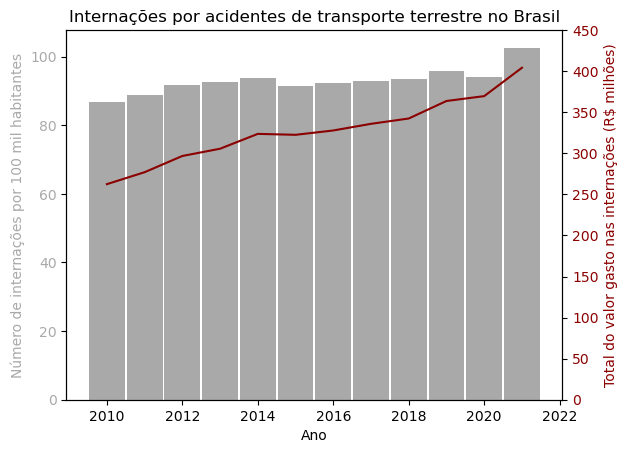

In [26]:
plt.style.use('default')
c = ['darkgrey', 'darkred']

fig, lax = plt.subplots()

lax.bar(indicadores_brasil.index, indicadores_brasil['inter_100k_ha'], 0.95, color=c[0])
lax.set_title('Internações por acidentes de transporte terrestre no Brasil')
lax.set_ylabel('Número de internações por 100 mil habitantes', color=c[0])
lax.tick_params(axis='y', labelcolor=c[0])
lax.set_xlabel('Ano')

rax = lax.twinx()
rax.plot(indicadores_brasil.index, indicadores_brasil['gasto_ano'].div(10**6), color=c[1])
rax.set_ylabel('Total do valor gasto nas internações (R$ milhões)', color=c[1])
rax.set_ylim(0, 450)
rax.tick_params(axis='y', labelcolor=c[1])
plt.show()

### Óbitos a cada 100 mil habitantes

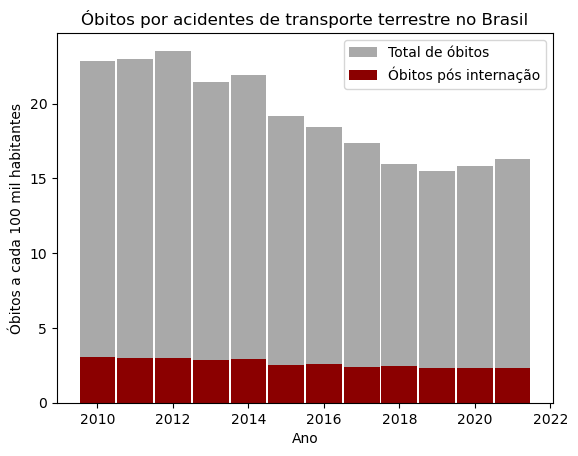

In [27]:
inter_com_obito_ano = sihsus.loc[sihsus['MORTE'] == 1, 'dt_inter'].dt.year.value_counts()
inter_com_obito_ano = inter_com_obito_ano.div(pop_100k_ano.sum()).dropna()

fig, ax = plt.subplots()
ax.bar(indicadores_brasil.index, indicadores_brasil['obitos_100k_ha'], 0.95, color='darkgrey', label='Total de óbitos')
ax.bar(inter_com_obito_ano.index, inter_com_obito_ano.values, 0.95, color='darkred', label='Óbitos pós internação')
ax.set_xlabel('Ano')
ax.set_ylabel('Óbitos a cada 100 mil habitantes')
ax.set_title('Óbitos por acidentes de transporte terrestre no Brasil')
ax.legend()
plt.show()

### Internações por veículo

In [28]:
br_inter_ano_veiculo = inter_ano_veiculo.groupby('ano').sum()
br_frota_10k_ano = frota_10k_ano.groupby('ano').sum()

# Adicionamos uma coluna 'frota' para representar o total de internações
# e possibilitar a divisão
br_inter_ano_veiculo['frota'] = br_inter_ano_veiculo.sum(axis=1)

br_inter_ano_veiculo = br_inter_ano_veiculo.div(br_frota_10k_ano).dropna(how='all').dropna(axis=1, how='all')
br_inter_ano_veiculo.rename(columns={'frota': 'Total da frota'}, inplace=True)
br_inter_ano_veiculo.describe()

,automóvel,caminhonete,Total da frota,motociclista,transporte pesado,triciclo,ônibus
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,2.780955,0.609782,23.003240,42.622792,2.541993,274.241467,4.130998
std,0.678141,0.063461,2.411630,0.856862,0.234437,90.225318,1.177109
min,1.927964,0.502735,20.072503,41.628908,2.098841,156.851524,2.104146
25%,2.153985,0.572685,21.272677,41.948815,2.392101,213.838391,3.211855
50%,2.726976,0.609990,22.085487,42.574652,2.512037,249.401127,4.384550
75%,3.148680,0.643133,24.773193,43.136534,2.680054,366.555006,5.139609
max,3.850706,0.725671,27.594450,44.352459,2.965641,398.150325,5.553017


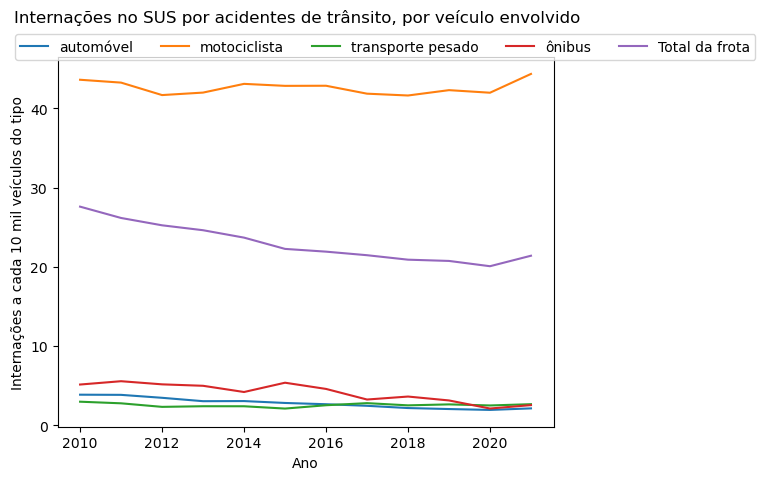

In [29]:
fig, ax = plt.subplots()

for vei in ['automóvel', 'motociclista', 'transporte pesado', 'ônibus', 'Total da frota']:
    ax.plot(br_inter_ano_veiculo.index, br_inter_ano_veiculo[vei], label=vei)

fig.suptitle('Internações no SUS por acidentes de trânsito, por veículo envolvido')
ax.set_xlabel('Ano')
ax.set_ylabel('Internações a cada 10 mil veículos do tipo')
ax.legend(ncols=5, bbox_to_anchor=(-0.1, 1.08), loc='upper left')
plt.show()

## Indicador comparativo de vulnerabilidade em segurança viária

A proposta trabalhada nesta seção foi a criação de um indicador unificado de insegurança viária para as regiões.

Considerando que existem discrepâncias entre a taxa de internações e a taxa de óbitos por acidentes de trânsito. Ou seja, que existem regiões com registros muito baixos ou nulos de internações, mas com quantidade de óbitos considerável.

Por isso, propomos uma leitura sobre a vulnerabilidade regional que considerasse a maior dentre as duas taxas. Para podermos compará-las, primeiro normalizamos cada uma das taxas pela diferência entre os valores mínimo e máximo de cada uma.

### Taxas médias em Q1 e Q2, por região

In [30]:
internacoes_100k_ha = internacoes_ano.div(pop_100k_ano).dropna(axis=1, how='all')
obitos_100k_ha = obitos_ano.div(pop_100k_ano).dropna(axis=1, how='all')

indicadores_por_regiao = pd.DataFrame({
    'inter_100k_ha_q1': internacoes_100k_ha.loc[:, :2017].mean(axis=1),
    'obitos_100k_ha_q1': obitos_100k_ha.loc[:, :2017].mean(axis=1),
    'inter_100k_ha_q2': internacoes_100k_ha.loc[:, 2018:].mean(axis=1),
    'obitos_100k_ha_q2': obitos_100k_ha.loc[:, 2018:].mean(axis=1),
})

indicadores_por_regiao

,inter_100k_ha_q1,obitos_100k_ha_q1,inter_100k_ha_q2,obitos_100k_ha_q2
regional_id,,,,
11001,102.501246,30.901944,164.732061,24.552681
11002,117.048174,32.850800,54.877003,29.112607
11003,141.037975,36.200129,100.930862,28.019876
11004,118.404261,31.025382,174.081563,17.404767
11005,163.561175,34.201661,145.112318,25.240001
...,...,...,...,...
52015,48.853435,32.248543,60.081143,24.489634
52016,33.183038,36.181846,31.692101,26.254766
52017,85.262214,32.146848,154.993267,24.120554


In [31]:
indicadores_por_regiao.describe()

,inter_100k_ha_q1,obitos_100k_ha_q1,inter_100k_ha_q2,obitos_100k_ha_q2
count,450.000000,450.000000,450.000000,450.000000
mean,94.917061,24.901885,103.740711,20.139643
std,69.351094,7.881244,72.291373,7.235228
min,2.339482,3.263961,2.918841,3.474946
25%,44.489091,19.360129,48.936852,14.740230
50%,85.030800,24.076063,95.515697,19.445020
75%,128.770773,30.367543,144.653241,24.403534
max,580.237096,47.565609,524.118805,41.885391


### Indicador unificado

In [32]:
indicadores_por_regiao = indicadores_por_regiao.mask(indicadores_por_regiao > 320, 320)

ind_normalizados = (
    (indicadores_por_regiao - indicadores_por_regiao.min())
    / (indicadores_por_regiao.max() - indicadores_por_regiao.min())
)

indices_regionais = pd.DataFrame({
    'indice_q1': ind_normalizados[['inter_100k_ha_q1', 'obitos_100k_ha_q1']].max(axis=1),
    'indice_q2': ind_normalizados[['inter_100k_ha_q2', 'obitos_100k_ha_q2']].max(axis=1),
})

indices_regionais['variacao_de_q1_para_q2'] = indices_regionais['indice_q2'] - indices_regionais['indice_q1']

indices_regionais.describe()

,indice_q1,indice_q2,variacao_de_q1_para_q2
count,450.000000,450.000000,450.000000
mean,0.514632,0.483609,-0.031023
std,0.183122,0.190483,0.111461
min,0.027016,0.063087,-0.526506
25%,0.385231,0.342156,-0.089837
50%,0.497161,0.462997,-0.040362
75%,0.633518,0.598819,0.015035
max,1.000000,1.000000,0.520459


### Comparativo entre regiões e indicadores

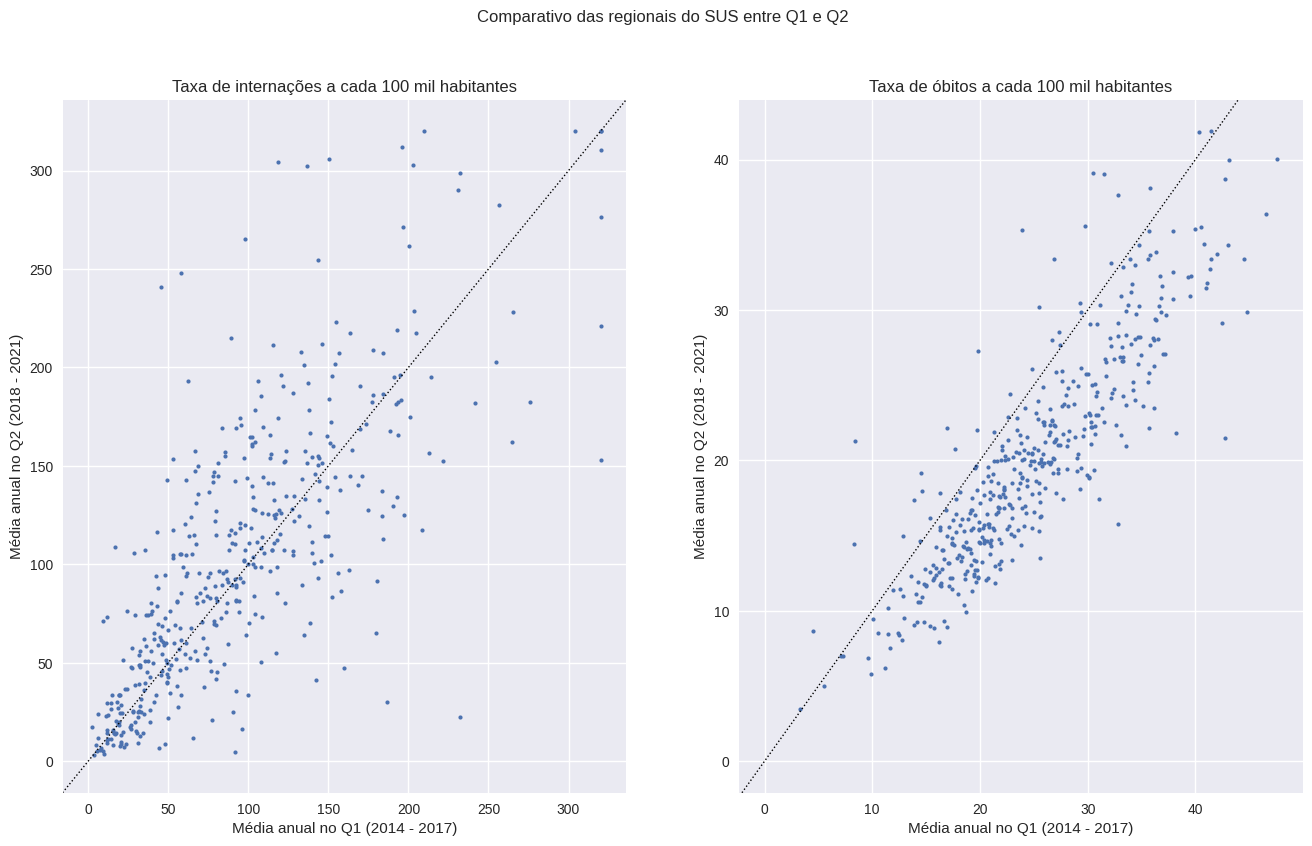

In [33]:
plt.style.use('seaborn-v0_8')

fig, axs = plt.subplots(1, 2, figsize=(16, 9)
)

fig.suptitle('Comparativo das regionais do SUS entre Q1 e Q2')

axs[0].plot('inter_100k_ha_q1', 'inter_100k_ha_q2',
        data=indicadores_por_regiao, marker='o', ls='', markersize=3
)
axs[0].set_title('Taxa de internações a cada 100 mil habitantes')

axs[0].set_xlabel('Média anual no Q1 (2014 - 2017)')
axs[0].set_ylabel('Média anual no Q2 (2018 - 2021)')
axs[0].axline([0,0], [1,1], ls=':', color='black', linewidth=1)

axs[1].plot('obitos_100k_ha_q1', 'obitos_100k_ha_q2',
            data=indicadores_por_regiao, marker='o', ls='', markersize=3
)
axs[1].set_title('Taxa de óbitos a cada 100 mil habitantes')

axs[1].set_xlabel('Média anual no Q1 (2014 - 2017)')
axs[1].set_ylabel('Média anual no Q2 (2018 - 2021)')
axs[1].axline([0,0],[1,1], ls=':', color='black', linewidth=1)

plt.show()

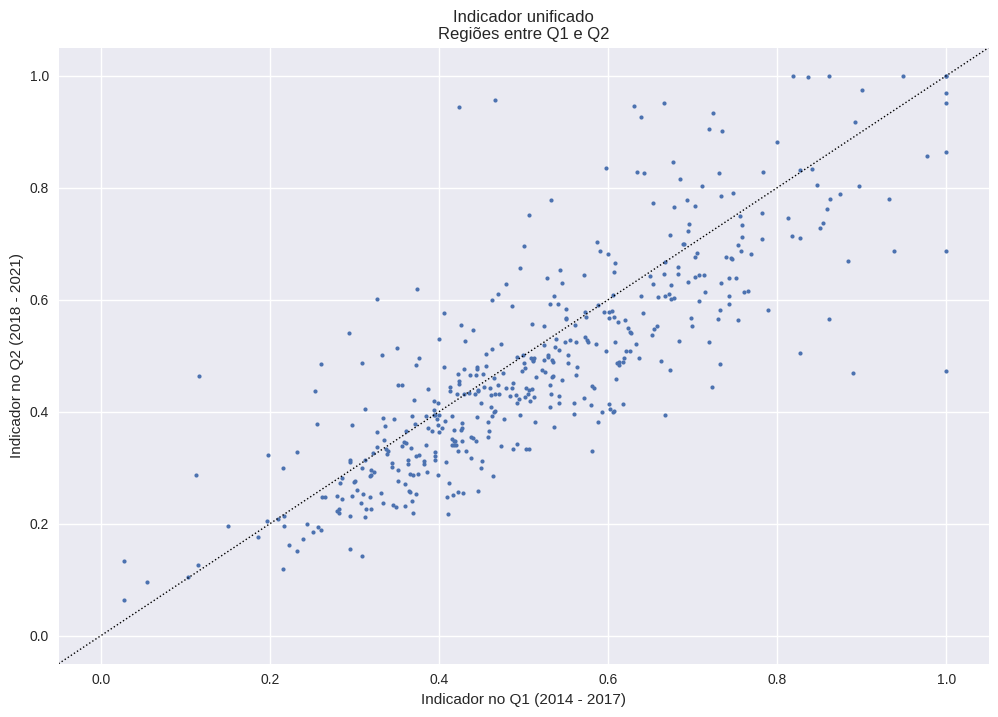

In [34]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot('indice_q1', 'indice_q2',
        data=indices_regionais, marker='o', ls='', markersize=3
)
ax.set_title(
    'Indicador unificado\n'
    'Regiões entre Q1 e Q2'
)

ax.set_xlabel('Indicador no Q1 (2014 - 2017)')
ax.set_ylabel('Indicador no Q2 (2018 - 2021)')
ax.axline([0,0], [1,1], ls=':', color='black', linewidth=1)

plt.show()

### Visualização do indicador de vulnerabilidade em segurança viária em Q2

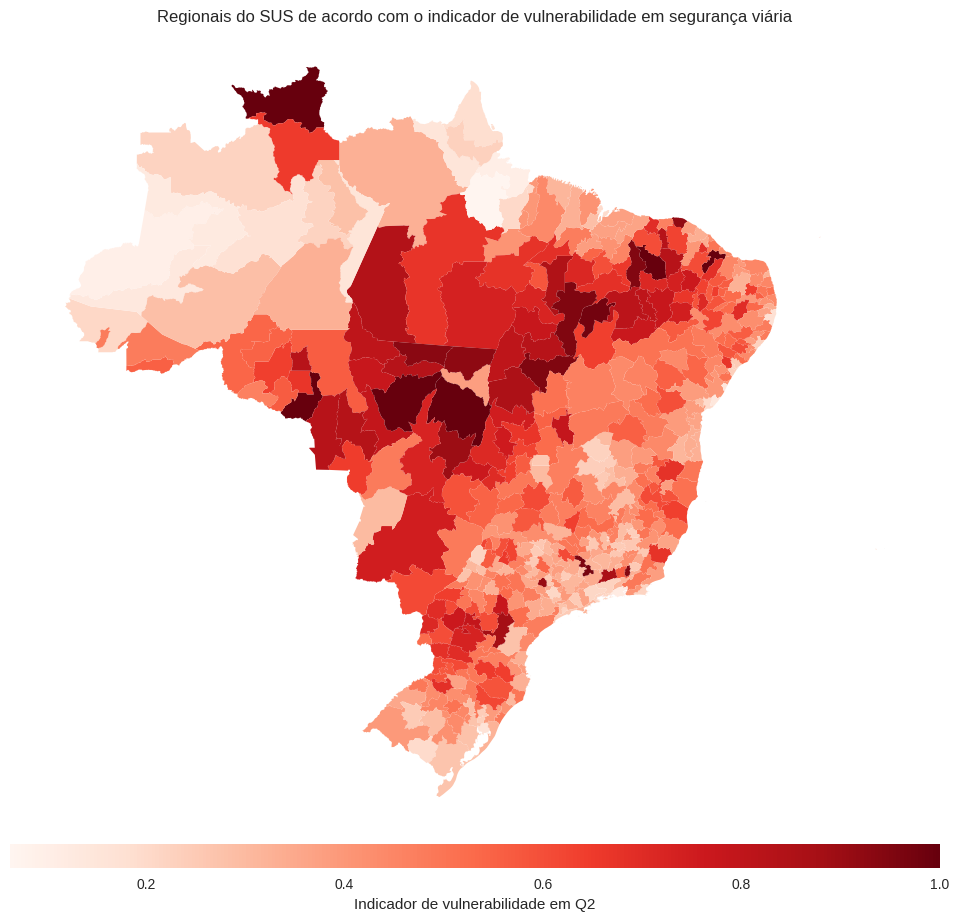

In [35]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title(
    'Regionais do SUS de acordo com o indicador de vulnerabilidade em segurança viária'
)
ax.set_aspect('equal')
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.1)

mapa_br_regionais.join(indices_regionais, on='reg_id').plot(
    column='indice_q2',
    cmap='Reds',
    ax=ax,
    cax=cax,
    legend=True,
    legend_kwds={
        'label': 'Indicador de vulnerabilidade em Q2',
        'orientation': 'horizontal',
    },
)

plt.show()

### Variação do indicador entre Q1 e Q2

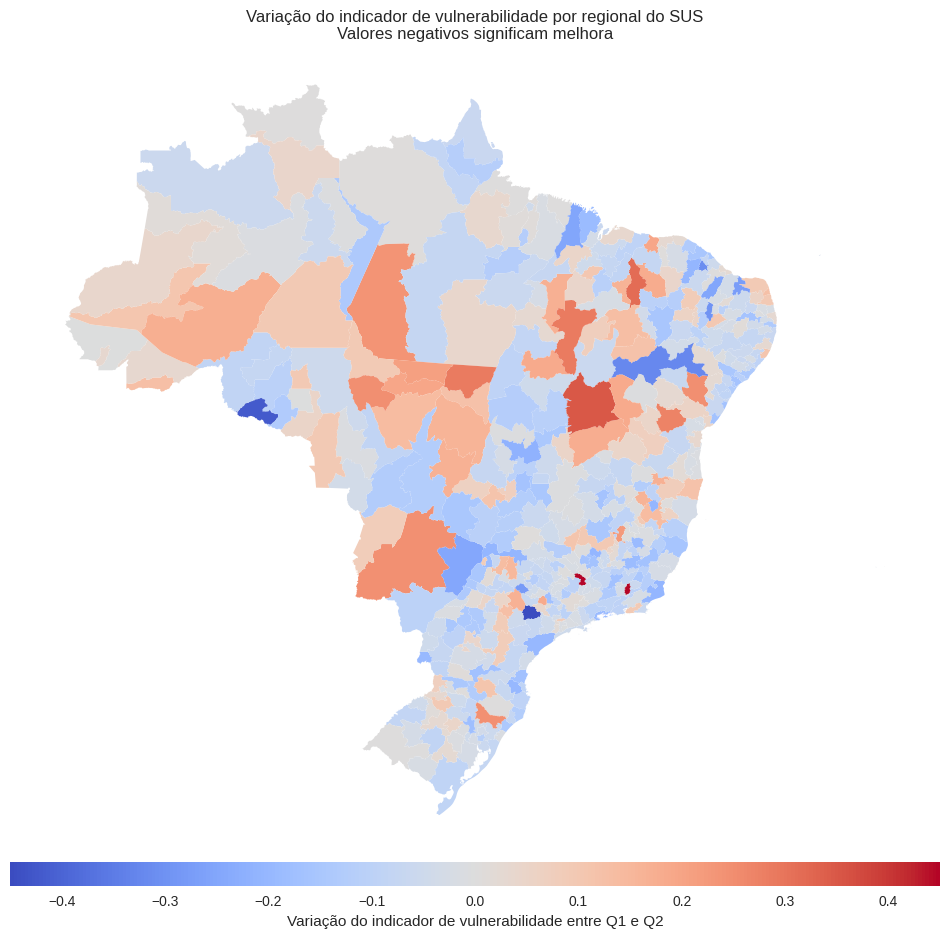

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_title(
    'Variação do indicador de vulnerabilidade por regional do SUS\n'
    'Valores negativos significam melhora'
)
ax.set_aspect('equal')
ax.axis('off')

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad=0.1)

mapa_br_regionais.join(indices_regionais, on='reg_id').plot(
    column='variacao_de_q1_para_q2',
    cmap='coolwarm',
    ax=ax,
    cax=cax,
    legend=True,
    legend_kwds={
        'label': 'Variação do indicador de vulnerabilidade entre Q1 e Q2',
        'orientation': 'horizontal',
    },
    vmin=-0.45, vmax=0.45,
)

plt.show()

## Recortes sobre a carteira

Nesta seção produzimos recortes na carteira de investimentos para adequá-la à série temporal sendo trabalhada, ou seja, entre investimentos realizados no quadriênio entre 2014 e 2017 e no seguinte, entre 2018 e 2021.

Os recortes consideraram obras concluídas no primeiro quadriênio e obras concluídas e iniciadas no segundo.

### Obras concluídas e contratadas em Q1 e Q2

In [37]:
mask = (
      (carteira['ano_inicio_obra'] >= 2010)
    & (carteira['ano_fim_obra'] <= 2017)
)
obra_concluida_q1 = carteira.loc[mask].groupby(['regional_id', 'programa'])['vlr_investimento'].sum()

mask = carteira['ano_fim_obra'] <= 2021
obra_concluida_q2 = carteira.loc[mask].groupby(['regional_id', 'programa'])['vlr_investimento'].sum()

mask = (
      (carteira['ano_assinatura'] >= 2018)
    & (carteira['ano_assinatura'] <= 2021)
)
    
obra_contratada_q2 = carteira.loc[mask].groupby(['regional_id', 'programa'])['vlr_investimento'].sum()

### Investimentos por programa e tamanho da região

In [38]:
obras_programa = pd.DataFrame({
    'concluida_q1': obra_concluida_q1.groupby('programa').sum(),
    'concluida q2': obra_concluida_q2.groupby('programa').sum(),
    'contratada q2': obra_contratada_q2.groupby('programa').sum()
})

obras_programa

,concluida_q1,concluida q2,contratada q2
programa,,,
AVANÇAR PÚBLICO,NaN,2.046228e+08,1.865374e+09
EMENDAS,3.988527e+09,1.536124e+10,1.051458e+10
PAC FIN,5.397926e+09,1.482498e+10,NaN
PAC OGU,6.542274e+08,5.514106e+09,NaN
PRÓ COMUNIDADE,NaN,1.012608e+06,NaN
SETOR PRIVADO,1.495090e+07,4.757666e+08,2.985040e+08


In [39]:
obras_tamanho_reg = pd.DataFrame({
    'concluida_q1': obra_concluida_q1.groupby('regional_id').sum().groupby(regionais_categoria_pop, observed=False).sum(),
    'concluida_q2': obra_concluida_q2.groupby('regional_id').sum().groupby(regionais_categoria_pop, observed=False).sum(),
    'contratada_q2': obra_contratada_q2.groupby('regional_id').sum().groupby(regionais_categoria_pop, observed=False).sum(),
})

obras_tamanho_reg.div(obras_tamanho_reg.sum())

,concluida_q1,concluida_q2,contratada_q2
categoria_pop,,,
Até 10 mil,0.000000,0.000000,0.000000
Até 50 mil,0.001048,0.001046,0.001650
Até 100 mil,0.007809,0.009409,0.032325
Até 300 mil,0.157592,0.156281,0.301555
Até 500 mil,0.124589,0.120271,0.181989
Até 1 milhão,0.115760,0.138261,0.216530
Mais de 1 milhão,0.593201,0.574732,0.265953


In [40]:
obra_contratada_q2.unstack().groupby(regionais_categoria_pop, observed=False).sum()

programa,AVANÇAR PÚBLICO,EMENDAS,SETOR PRIVADO
categoria_pop,,,
Até 10 mil,0.000000e+00,0.000000e+00,0.000000e+00
Até 50 mil,1.577685e+06,1.933555e+07,0.000000e+00
Até 100 mil,2.064244e+07,3.891864e+08,0.000000e+00
Até 300 mil,5.756570e+08,3.247002e+09,5.920000e+05
Até 500 mil,3.774003e+08,1.929935e+09,1.000000e-02
Até 1 milhão,4.116372e+08,2.327145e+09,6.480000e+06
Mais de 1 milhão,4.784597e+08,2.601976e+09,2.914320e+08


## Correlação indicador de vulnerabilidade com carteira

### Variação do indicador por tipo de programa e valor de investimento

Para esta plotagem, classificamos os municípios de acordo com o motante investido no quadriênio 2014-2017. A classificação se deu por quartis, sendo considerados investimento "baixo" os municípios que estão na faixa dos 25% com menos investimentos e "muito alto" os que estão na faixa dos 25% com mais investimentos.

O montante investido foi tomado como a somatória do valor das obras concluídas no período, dividido pelo número de habitantes em cada regional do SUS.

A expectativa era que houvesse uma concetração maior de regiões com alto investimento no triângulo inferior do gráfico, ou seja, nas regiões com melhora do indicador de vulnerabilidade. O que não se confirmou.

Para efeito comparativo, também marcamos as regiões de acordo com a tipo de programa que investiu mais na região em questão.

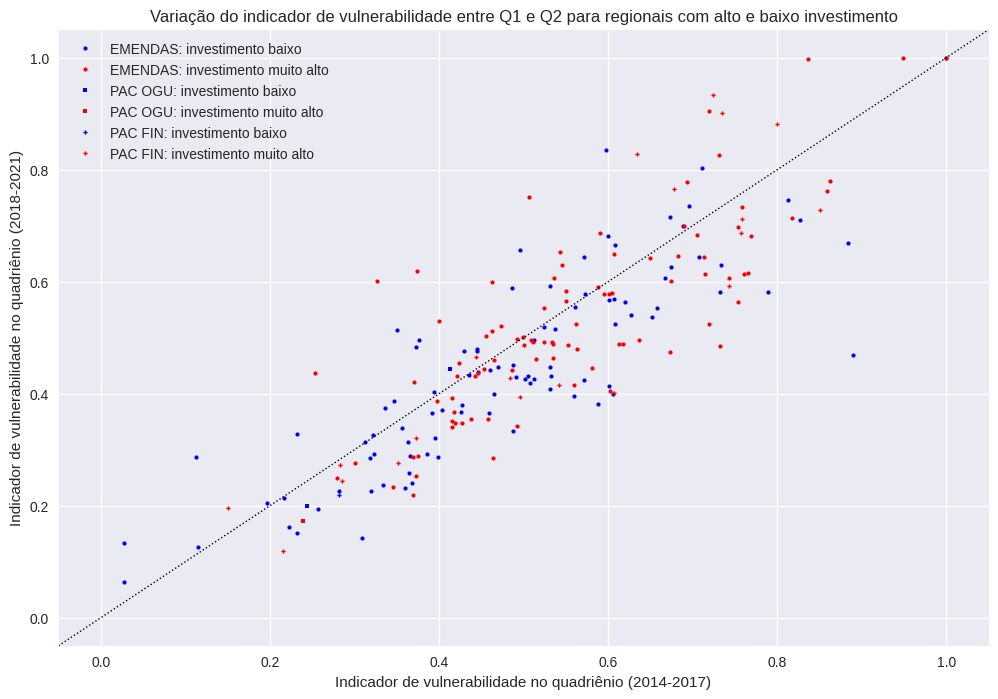

In [41]:
SYMBOLS = ['o', 's', 'P', 'X', 'p', '*']
CAT_INVEST = ['baixo', 'médio', 'alto', 'muito alto']

concluida_q1_programa = obra_concluida_q1.unstack().div(pop_ano[2017], axis=0)

maior_programa = concluida_q1_programa.dropna(how='all').idxmax(axis=1)
soma_invest_qtd = pd.qcut(concluida_q1_programa.sum(axis=1), 4, labels=CAT_INVEST)

fig, ax = plt.subplots(figsize=(12, 8))

for prog, sym in zip(maior_programa.unique(), SYMBOLS[:maior_programa.nunique()]):
    for cat, color in zip(['baixo', 'muito alto'], ['blue', 'red']):
        to_plot = indices_regionais.loc[(maior_programa == prog) & (soma_invest_qtd == cat)]
        label = f'{prog}: investimento {cat}'
        ax.plot('indice_q1', 'indice_q2', data=to_plot, ls='', marker=sym, color=color, markersize=3, label=label)

ax.set_title('Variação do indicador de vulnerabilidade entre Q1 e Q2 para regionais com alto e baixo investimento')
ax.set_ylabel('Indicador de vulnerabilidade no quadriênio (2018-2021)')
ax.set_xlabel('Indicador de vulnerabilidade no quadriênio (2014-2017)')
ax.axline([0,0],[1,1], ls=':', color='black', linewidth=1)
ax.legend()
plt.show()

Na plotagem abaixo, as regiões são classificadas de acordo com a variação do indicador de vulnerabilidade em segurança viária entre Q1 e Q2, no eixo X e o montante investido por habitante, no exito Y.

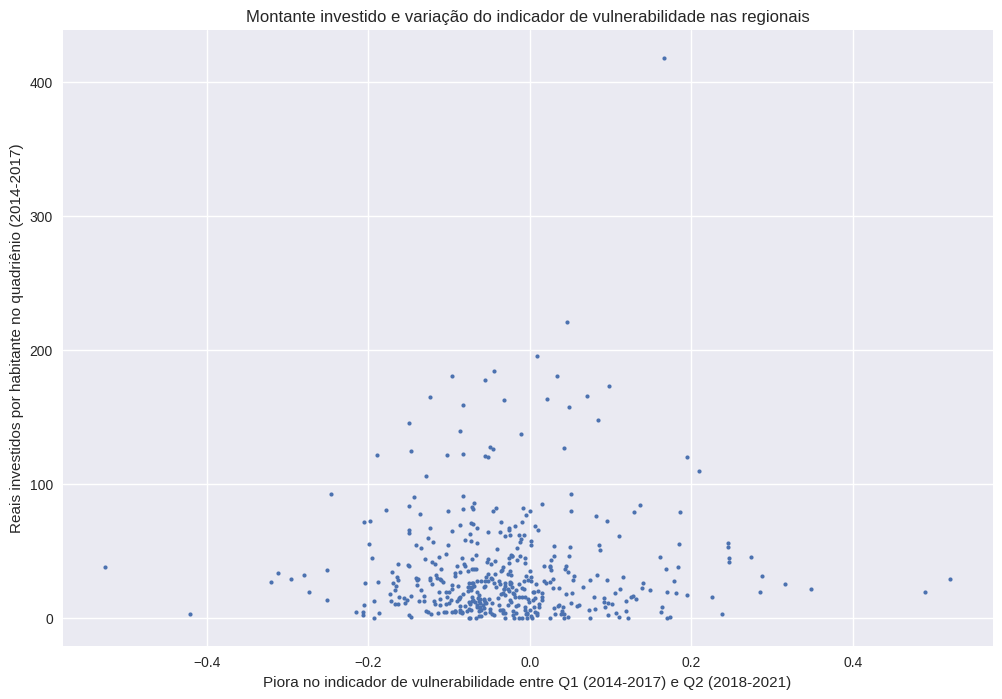

In [42]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(
    indices_regionais['variacao_de_q1_para_q2'].sort_index(),
    concluida_q1_programa.sum(axis=1).sort_index(),
    ls='', marker='o', markersize=3
)

ax.set_title('Montante investido e variação do indicador de vulnerabilidade nas regionais')
ax.set_ylabel('Reais investidos por habitante no quadriênio (2014-2017)')
ax.set_xlabel('Piora no indicador de vulnerabilidade entre Q1 (2014-2017) e Q2 (2018-2021)')

plt.show()

### Investimento reativo

Na plotagem abaixo, classificamos as regionais de acordo com o indicador de vulnerabilidade em segurança viária no quadriênio 2014-2017 e o montante investido no quadriênio seguinte.

O montante investido foi tomado como a somatória do valor das obras que foram contratadas entre 2018 e 2021. A proposta era entender se havia algum padrão dos investimentos em regiões com alto indicador de vulnerabilidade em segurança viária.

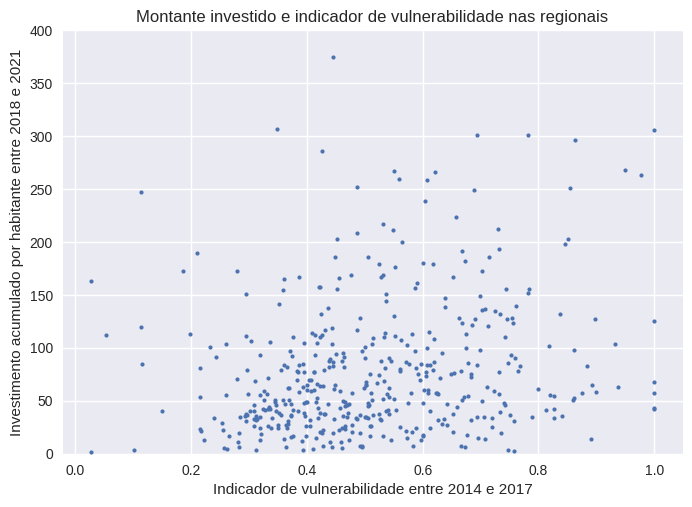

In [43]:
fig, ax = plt.subplots()
ax.plot(
    indices_regionais['indice_q1'].sort_index(),
    obra_contratada_q2.unstack().sum(axis=1).div(pop_ano[2021]).sort_index(),
    ls='', marker='o', markersize=3
)

ax.set_title('Montante investido e indicador de vulnerabilidade nas regionais')
ax.set_xlabel('Indicador de vulnerabilidade entre 2014 e 2017')
ax.set_ylabel('Investimento acumulado por habitante entre 2018 e 2021')
ax.set_ylim(0, 400)
fig.savefig('corr_invest_no_q2_com_indice_q1.png')
plt.show()